In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "6"

In [2]:
import tensorflow as tf

2025-06-21 05:32:02.910488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750509122.938497   73245 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750509122.946836   73245 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750509122.968122   73245 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750509122.968162   73245 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750509122.968165   73245 computation_placer.cc:177] computation placer alr

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## Libraries

In [6]:
import os
import shutil # Copy, move, delete files and folders
import tempfile 

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F # Pre-built math functions for neural networks
from monai import transforms # Tools to resize, rotate, normalize medical images
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader # Feed data to your model in batches
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast # Speed up training on GPU
from torch.nn import L1Loss # A way to measure how wrong predictions are
from tqdm import tqdm # Show progress bars during training

from generative.inferers import LatentDiffusionInferer # The main tool that generates images
from generative.losses import PatchAdversarialLoss, PerceptualLoss # Ways to measure image quality
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator # The AI models
from generative.networks.schedulers import DDPMScheduler # Controls the noise-adding process

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /ifs/loni/faculty/thompson/four_d/dhruvkudalkar/envs/myenv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.4.3
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.2
Pillow version: 11.2.1
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: 1.6.2
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: 4.52.4
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.1.3
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-t

In [7]:
# for reproducibility purposes set a seed
set_determinism(42)

## Setup a data directory and Prepare data loader for the training set

In [8]:
import pandas as pd
from monai.data import Dataset, DataLoader
# Load your CSV dataset
dataset_path = "/ifs/loni/faculty/thompson/four_d/vdesai/PEFT/male_dataset.csv"
df = pd.read_csv(dataset_path)
print(f"Dataset contains {len(df)} brain scans")
print(f"Sample file path: {df['Location'].iloc[0]}")

# Each dictionary should have "image" key pointing to file path
data_dicts = []
for idx, row in df.iterrows():
    data_dicts.append({
        "image": row["Location"],  # File path from CSV
        "sex": row["Sex"]          # Sex information (if needed later)
    })
    
print(f"First sample: {data_dicts[0]}")

Dataset contains 316 brain scans
Sample file path: /ifs/loni/faculty/thompson/four_d/kozarkar/Diffusion/medicaldiffusion/data/CAMCAN/images/MALE/sub-CC721052_model-DTI_MD.nii.gz
First sample: {'image': '/ifs/loni/faculty/thompson/four_d/kozarkar/Diffusion/medicaldiffusion/data/CAMCAN/images/MALE/sub-CC721052_model-DTI_MD.nii.gz', 'sex': 0}


In [9]:
# Training parameters
batch_size = 2  # Process 2 brain scans simultaneously
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),                    # Load the image file from disk
        transforms.EnsureChannelFirstd(keys=["image"]),           # Make sure image format is correct
        transforms.EnsureTyped(keys=["image"]),                   # Make sure it's the right data type
        transforms.Orientationd(keys=["image"], axcodes="RAS"),   # Rotate image to standard orientation
        transforms.Spacingd(keys=["image"], pixdim=(2.4, 2.4, 2.2), mode=("bilinear")),  # Resize pixels to standard size
        transforms.Resized(keys=["image"], spatial_size=(96, 96, 64), mode="trilinear"), # Match your DTI image dimensions,  # Cut out center 96x96x64 piece
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),  # Normalize brightness (0 to 1)
    ]
)

train_ds = Dataset(
    data=data_dicts,           # Your list of data dictionaries
    transform=train_transforms  # Apply the transforms
)

# Create DataLoader
train_loader = DataLoader(
    train_ds, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=8,        # Reduced from 8 - adjust based on your system
    persistent_workers=True
)

In [10]:
print(f'Image shape: {train_ds[0]["image"].shape}')
print(f'Data type: {train_ds[0]["image"].dtype}')

Image shape: torch.Size([1, 96, 96, 64])
Data type: torch.float32


## Visualise examples from the training set

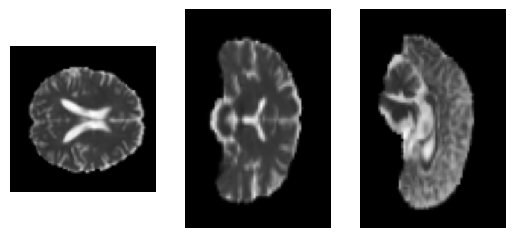

In [11]:
# Plot axial, coronal and sagittal slices of a training sample
check_data = first(train_loader)
idx = 0

img = check_data["image"][idx, 0]
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")
# plt.savefig("training_examples.png")

## Autoencoder KL

In this section, we will define an autoencoder with KL-regularization for the LDM. The autoencoder's primary purpose is to transform input images into a latent representation that the diffusion model will subsequently learn. By doing so, we can decrease the computational resources required to train the diffusion component, making this approach suitable for learning high-resolution medical images.

Without KL: Codes are chaotic → can't generate new images
With KL: Codes are organized → can generate infinite new brain scans

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [13]:
autoencoder = AutoencoderKL(
    spatial_dims=3, # Working with 3D volumes 
    in_channels=1, # Input: 1 channel (grayscale brain scan)
    out_channels=1, # Output: 1 channel (reconstructed grayscale brain scan)
    num_channels=(32, 64, 64), # Network gets wider as it goes deeper: 32→64→64 filters
    latent_channels=3, # Compress to 3-channel latent code (much smaller than original)
    num_res_blocks=1, # Use 1 residual block per level (helps with training)
    # Add a "shortcut" that carries the original input directly to the output, then combine it with what the layers learned.
    norm_num_groups=16, # Normalization setting (helps training stability)
    attention_levels=(False, False, True), # Only use attention at the deepest level
)
autoencoder.to(device)

discriminator = PatchDiscriminator(spatial_dims=3, num_layers_d=3, num_channels=32, in_channels=1, out_channels=1)
discriminator.to(device)

PatchDiscriminator(
  (initial_conv): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (adn): ADN(
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (0): Convolution(
    (conv): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (1): Convolution(
    (conv): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (adn): ADN(
      (N): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (D): Dropout(p=0.0, inplace=False)
      (A): LeakyReLU(negative_slope=0.2)
    )
  )
  (2): Convolution(
    (conv): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=(1, 1, 1), bias=Fal

## Defining Losses

In training:

L1 loss (strongest): "Make it look exactly right!"
Adversarial (medium): "Make it look realistic!"
Perceptual (weak): "Keep the important medical features!"
KL (very weak): "Keep the latent space organized for generation!"

Real-world analogy:
Think of training a medical illustrator:

L1: Copy every single line perfectly
Adversarial: Make it look like a real medical scan
Perceptual: Don't lose the important medical details
KL: Keep your drawing style consistent for future work

In [14]:
# Simple example: If original pixel = 0.8, reconstructed = 0.6, loss = |0.8 - 0.6| = 0.2
# Goal: Make reconstructed image look exactly like original, pixel by pixel
l1_loss = L1Loss()
# What it does: Encourages autoencoder to fool the discriminator
# Goal: Make fake images so good that discriminator thinks they're real
adv_loss = PatchAdversarialLoss(criterion="least_squares")
# What it does: Compares "what the image looks like" rather than individual pixels
# Example: Both images show a brain tumor, even if pixels are slightly different
# Goal: Preserve important medical features (tumors, anatomy) rather than just copying pixels
loss_perceptual = PerceptualLoss(spatial_dims=3, network_type="squeeze", is_fake_3d=True, fake_3d_ratio=0.2)
loss_perceptual.to(device)

# What it does: Forces the compressed codes to follow a nice, organized pattern
# Goal: Make sure you can generate new brain scans later by sampling random codes
def KL_loss(z_mu, z_sigma):
    kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3, 4])
    return torch.sum(kl_loss) / kl_loss.shape[0]


adv_weight = 0.01 # Adversarial loss: 1% importance
perceptual_weight = 0.001 # Perceptual loss: 0.1% importance  
kl_weight = 1e-6 # KL loss: 0.0001% importance

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.


In [15]:
optimizer_g = torch.optim.Adam(params=autoencoder.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=1e-4)

## Train model

In [16]:
# Training parameters
n_epochs = 100 # Train for 100 complete passes through all the data
autoencoder_warm_up_n_epochs = 5 # For the first 5 epochs, only train the autoencoder (no discriminator competition yet)
val_interval = 10 # Test the model every 10 epochs
checkpoint_file = "latest_checkpoint.pth"  # Checkpoint filename

# Initialize lists
epoch_recon_loss_list = [] # Empty list to store reconstruction loss for each epoch
epoch_gen_loss_list = [] # Empty list to store generator loss for each epoch
epoch_disc_loss_list = [] # Empty list to store discriminator loss for each epoch
val_recon_epoch_loss_list = [] # Empty list to store validation reconstruction losses
intermediary_images = [] # Empty list to store example images during training
n_example_images = 4

# Starting epoch
start_epoch = 0

# Load checkpoint if it exists
if os.path.exists(checkpoint_file):
    print(f"Loading checkpoint from {checkpoint_file}")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    
    # Load model states
    autoencoder.load_state_dict(checkpoint['autoencoder_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    
    # Load optimizer states
    optimizer_g.load_state_dict(checkpoint['optimizer_g_state_dict'])
    optimizer_d.load_state_dict(checkpoint['optimizer_d_state_dict'])
    
    # Load training progress
    start_epoch = checkpoint['epoch'] + 1  # Start from next epoch
    epoch_recon_loss_list = checkpoint['epoch_recon_loss_list']
    epoch_gen_loss_list = checkpoint['epoch_gen_loss_list']
    epoch_disc_loss_list = checkpoint['epoch_disc_loss_list']
    val_recon_epoch_loss_list = checkpoint.get('val_recon_epoch_loss_list', [])
    intermediary_images = checkpoint.get('intermediary_images', [])
    
    print(f"Resuming training from epoch {start_epoch}")
else:
    print("No checkpoint found. Starting training from scratch.")

# Training loop
for epoch in range(start_epoch, n_epochs):
    autoencoder.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, batch in progress_bar:
        images = batch["image"].to(device)  # Move current batch of brain scans from CPU to GPU
        # Generator part
        optimizer_g.zero_grad(set_to_none=True) # Clear any leftover gradients from previous batch (generator optimizer)
        reconstruction, z_mu, z_sigma = autoencoder(images) # Pass brain scans through autoencoder, get back: reconstructed images + latent statistics
        kl_loss = KL_loss(z_mu, z_sigma) # Calculate KL loss to keep latent space organized
        recons_loss = l1_loss(reconstruction.float(), images.float()) # Calculate how different reconstruction is from original (pixel-by-pixel)
        p_loss = loss_perceptual(reconstruction.float(), images.float()) # Calculate perceptual loss (high-level feature differences)
        loss_g = recons_loss + kl_weight * kl_loss + perceptual_weight * p_loss # Combine all losses with their weights to get total generator loss
        if epoch > autoencoder_warm_up_n_epochs:
            logits_fake = discriminator(reconstruction.contiguous().float())[-1] # Ask discriminator: "How fake does this reconstruction look?" (get last layer output)
            generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False) # Calculate loss to make generator fool discriminator ("pretend this is real!")
            loss_g += adv_weight * generator_loss # Add weighted adversarial loss to total generator loss
        loss_g.backward()
        optimizer_g.step()
        if epoch > autoencoder_warm_up_n_epochs:
            # Discriminator part
            optimizer_d.zero_grad(set_to_none=True)
            logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
            loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            logits_real = discriminator(images.contiguous().detach())[-1]
            loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            discriminator_loss = (loss_d_fake + loss_d_real) * 0.5
            loss_d = adv_weight * discriminator_loss
            loss_d.backward()
            optimizer_d.step()
        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()
        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    
    # Save losses for this epoch
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))
    
    # Save checkpoint every epoch
    checkpoint = {
        'epoch': epoch,
        'autoencoder_state_dict': autoencoder.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_g_state_dict': optimizer_g.state_dict(),
        'optimizer_d_state_dict': optimizer_d.state_dict(),
        'epoch_recon_loss_list': epoch_recon_loss_list,
        'epoch_gen_loss_list': epoch_gen_loss_list,
        'epoch_disc_loss_list': epoch_disc_loss_list,
        'val_recon_epoch_loss_list': val_recon_epoch_loss_list,
        'intermediary_images': intermediary_images,
    }
    torch.save(checkpoint, checkpoint_file)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs} - Checkpoint saved!")

print("Training completed!")

# Clean up
del discriminator
del loss_perceptual
torch.cuda.empty_cache()

# Optional: Remove checkpoint file after successful completion
# os.remove(checkpoint_file)  # Uncomment if you want to delete checkpoint after training

Loading checkpoint from latest_checkpoint.pth
Resuming training from epoch 100
Training completed!


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


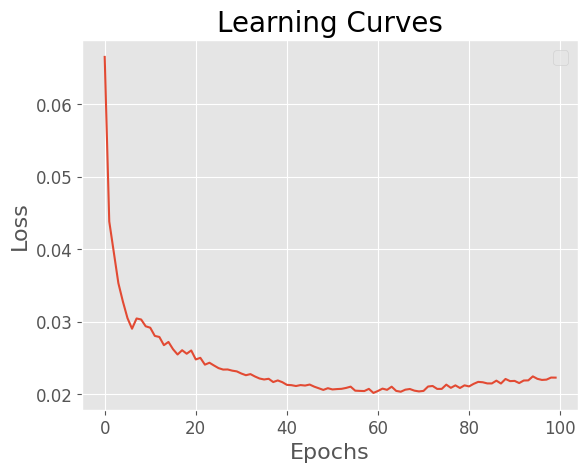

In [17]:
plt.style.use("ggplot")
plt.title("Learning Curves", fontsize=20)
plt.plot(epoch_recon_loss_list)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

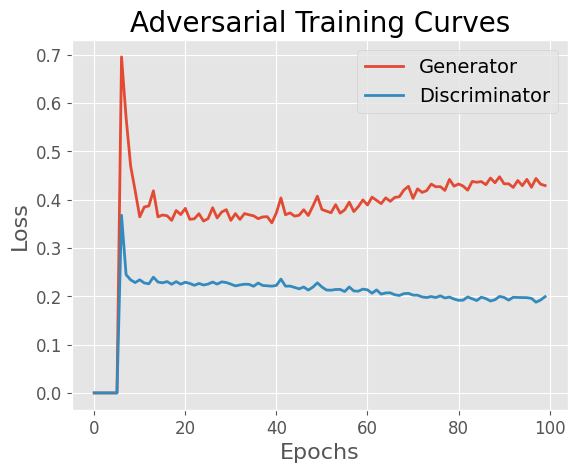

In [18]:
plt.title("Adversarial Training Curves", fontsize=20)
plt.plot(epoch_gen_loss_list, color="C0", linewidth=2.0, label="Generator")
plt.plot(epoch_disc_loss_list, color="C1", linewidth=2.0, label="Discriminator")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

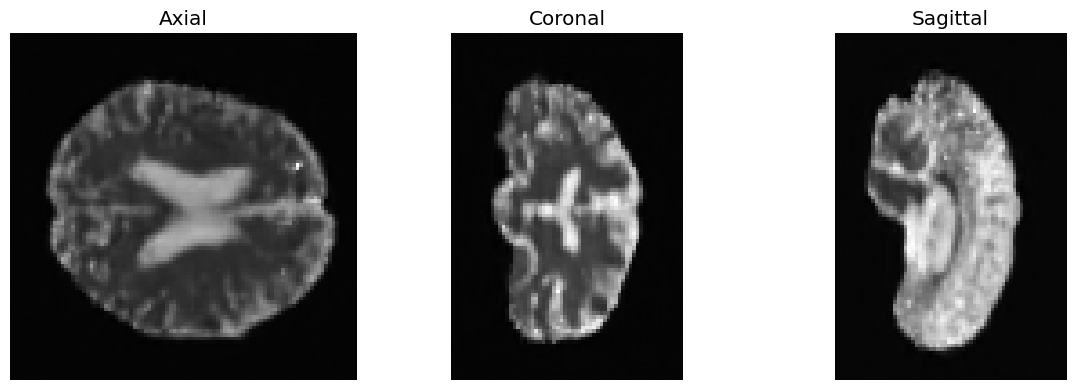

In [19]:
# Get a fresh reconstruction from your trained autoencoder
autoencoder.eval()
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    images = sample_batch["image"].to(device)
    reconstruction, z_mu, z_sigma = autoencoder(images)

# Plot axial, coronal and sagittal slices of a training sample
idx = 0
img = reconstruction[idx, 0].detach().cpu().numpy()  # [0] for first channel since single-channel
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for ax in axs:
    ax.axis("off")

# Axial slice
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax.set_title("Axial")

# Coronal slice  
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax.set_title("Coronal")

# Sagittal slice
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")
ax.set_title("Sagittal")

plt.tight_layout()
plt.show()

## Diffusion Model

### Define diffusion model and scheduler

In this section, we will define the diffusion model that will learn data distribution of the latent representation of the autoencoder. Together with the diffusion model, we define a beta scheduler responsible for defining the amount of noise that is added across the diffusion's model Markov chain.

Beta scheduler is like a "noise recipe" that controls how to gradually transform clean brain scans into noise (and back again) in a way that the AI can learn!

Visual Rule:

SAFE: Anything with "middle" in the name
DANGEROUS: Anything with "down_blocks" or "up_blocks"
MAYBE SAFE: Input/output layers (conv_in, out)

Bottom line: When in doubt, stick to middle_block - it's the bottleneck of the U-Net and never has skip connections!

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from monai.utils import first
import os

# SVDiff implementation
class SVDConv2d(nn.Module):
    """Conv2d layer with SVD decomposition for fine-tuning only singular values"""
    def __init__(self, conv_layer, learning_rate_scale=1000):
        super().__init__()
        self.in_channels = conv_layer.in_channels
        self.out_channels = conv_layer.out_channels
        self.kernel_size = conv_layer.kernel_size
        self.stride = conv_layer.stride
        self.padding = conv_layer.padding
        self.dilation = conv_layer.dilation
        self.groups = conv_layer.groups
        
        # Get the weight tensor and reshape for SVD
        weight = conv_layer.weight.data  # Shape: [out_channels, in_channels, H, W]
        self.weight_shape = weight.shape
        
        # Reshape to 2D for SVD: [out_channels, in_channels * H * W]
        weight_2d = weight.reshape(self.out_channels, -1)
        
        # Perform SVD (this is done once and cached)
        U, sigma, Vt = torch.linalg.svd(weight_2d, full_matrices=False)
        
        # Store U and V^T as non-trainable
        self.register_buffer('U', U)
        self.register_buffer('Vt', Vt)
        self.register_buffer('sigma_orig', sigma)
        
        # Initialize spectral shift δ as trainable parameter
        self.delta = nn.Parameter(torch.zeros_like(sigma))
        
        # Store bias if exists
        if conv_layer.bias is not None:
            self.bias = nn.Parameter(conv_layer.bias.data.clone())
        else:
            self.register_parameter('bias', None)
            
        # Learning rate scale for spectral shifts
        self.lr_scale = learning_rate_scale
        
    def forward(self, x):
        # Reconstruct weight: W = U @ diag(ReLU(σ + δ)) @ V^T
        sigma_new = F.relu(self.sigma_orig + self.delta)
        weight_2d = self.U @ torch.diag(sigma_new) @ self.Vt
        
        # Reshape back to conv weight shape
        weight = weight_2d.reshape(self.weight_shape)
        
        # Perform convolution
        return F.conv2d(x, weight, self.bias, self.stride, self.padding, 
                       self.dilation, self.groups)

class SVDConv3d(nn.Module):
    """Conv3d layer with SVD decomposition"""
    def __init__(self, conv_layer, learning_rate_scale=1000):
        super().__init__()
        # Store conv parameters
        self.in_channels = conv_layer.in_channels
        self.out_channels = conv_layer.out_channels
        self.kernel_size = conv_layer.kernel_size
        self.stride = conv_layer.stride
        self.padding = conv_layer.padding
        self.dilation = conv_layer.dilation
        self.groups = conv_layer.groups
        
        # Get weight and reshape for SVD
        weight = conv_layer.weight.data  # [out, in, D, H, W]
        self.weight_shape = weight.shape
        
        # Reshape to 2D: [out_channels, in_channels * D * H * W]
        weight_2d = weight.reshape(self.out_channels, -1)
        
        # SVD
        U, sigma, Vt = torch.linalg.svd(weight_2d, full_matrices=False)
        
        # Store as buffers
        self.register_buffer('U', U)
        self.register_buffer('Vt', Vt)
        self.register_buffer('sigma_orig', sigma)
        
        # Trainable spectral shift
        self.delta = nn.Parameter(torch.zeros_like(sigma))
        
        # Bias
        if conv_layer.bias is not None:
            self.bias = nn.Parameter(conv_layer.bias.data.clone())
        else:
            self.register_parameter('bias', None)
            
    def forward(self, x):
        sigma_new = F.relu(self.sigma_orig + self.delta)
        weight_2d = self.U @ torch.diag(sigma_new) @ self.Vt
        weight = weight_2d.reshape(self.weight_shape)
        return F.conv3d(x, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [31]:
class SVDLinear(nn.Module):
    """Linear layer with SVD decomposition"""
    def __init__(self, linear_layer, learning_rate_scale=1000):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        
        # Perform SVD on weight matrix
        weight = linear_layer.weight.data
        U, sigma, Vt = torch.linalg.svd(weight, full_matrices=False)
        
        # Store as buffers (non-trainable)
        self.register_buffer('U', U)
        self.register_buffer('Vt', Vt)
        self.register_buffer('sigma_orig', sigma)
        
        # Trainable spectral shift
        self.delta = nn.Parameter(torch.zeros_like(sigma))
        
        # Bias
        if linear_layer.bias is not None:
            self.bias = nn.Parameter(linear_layer.bias.data.clone())
        else:
            self.register_parameter('bias', None)
            
        self.lr_scale = learning_rate_scale
        
    def forward(self, x):
        sigma_new = F.relu(self.sigma_orig + self.delta)
        weight = self.U @ torch.diag(sigma_new) @ self.Vt
        return F.linear(x, weight, self.bias)

In [32]:
def apply_svdiff_to_model(model, conv_lr_scale=1000, linear_lr_scale=1000, 
                         apply_to_1d_conv=True):
    """
    Apply SVDiff to a model by replacing Conv2d and Linear layers
    
    Args:
        model: The model to apply SVDiff to
        conv_lr_scale: Learning rate scale for Conv2d layers
        linear_lr_scale: Learning rate scale for Linear layers
        apply_to_1d_conv: Whether to apply to 1D convolutions (kernel size 1x1)
    """
    for name, module in model.named_children():
        if isinstance(module, nn.Conv2d):
            # Check if it's a 1x1 conv (1D in the paper's terminology)
            is_1x1 = module.kernel_size == (1, 1) or module.kernel_size == 1
            if not is_1x1 or apply_to_1d_conv:
                setattr(model, name, SVDConv2d(module, conv_lr_scale))
        elif isinstance(module, nn.Linear):
            setattr(model, name, SVDLinear(module, linear_lr_scale))
        else:
            # Recursively apply to child modules
            apply_svdiff_to_model(module, conv_lr_scale, linear_lr_scale, apply_to_1d_conv)

In [33]:
unet = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=3,
    out_channels=3,
    num_res_blocks=1,
    num_channels=(32, 64, 64),
    attention_levels=(False, True, True),
    num_head_channels=(0, 64, 64),
)
unet.to(device)

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler)

In [34]:
# Apply SVDiff to the model
print("Applying SVDiff to the model...")
apply_svdiff_to_model(unet)
print("SVDiff applied successfully!")

# Count parameters
total_params = 0
trainable_params = 0

for name, param in unet.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()

# Also count buffers (frozen U and V^T matrices)
for name, buffer in unet.named_buffers():
    if buffer is not None:
        total_params += buffer.numel()

ratio = trainable_params / total_params if total_params > 0 else 0

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Trainable parameter ratio: {ratio:.4f}")

Applying SVDiff to the model...
SVDiff applied successfully!

Total parameters: 3,147,107
Trainable parameters: 2,763,619
Trainable parameter ratio: 0.8781
